In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#geospatial libraries
import contextily as ctx
import geopandas as gpd

# imports necessary to generate arabic word clouds
import codecs
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

# translation library
from deep_translator import GoogleTranslator

## Dialects Map

Import dataframe with political tweets including dialect feature.

In [99]:
df_dialects = pd.read_parquet('/Users/richard/Desktop/data_cap3/interim/df_political_for_clustering_with_dialect_and_sentiment.parquet',
                              engine='pyarrow'
)

In [100]:
df_dialects.head()

,unique_tweetid,tweet_text,hashtags,is_retweet,retweet_tweetid,first_user,first_timestamp,gsdmm_topic,dialect_pred,sentiment_pred
0,11,"[عاجِل_1, نَبَأ_1, دِبلُوماسِيّ_2, تَلّ_1, أَب...",[عاجل],True,9.999468e+17,0,2018-05-25 13:07:00,11,MUS,negative
1,16,"[عُنْصُر_1, مِيلِيشِيا_1, الحوثي_0, قَتَل-u_1,...","[الحوثي, التحالف العربي, اليمن, الحاضر العربي]",False,NaN,5,2018-05-25 13:08:00,12,ALG,neutral
3,29,"[اللوء_0, رُكْن_2, مانِع_2, عُمَر_1, ابالعلاء_...",None,True,9.995083e+17,58,2018-05-25 00:27:00,18,SAN,neutral
4,36,"[ٱِنْتَظَر_1, جَبان_1, أُكْذُوبَة_1, تارِيخ_1,...",None,False,NaN,1,2018-05-25 13:10:00,12,MSA,negative
6,142,"[مشوفتش_0, خُلْق_1, مَبْدَأ_1, فَضِيحَة_1, قَر...","[فضيحة القرن, احد الاندية العربية]",True,1.000005e+18,22,2018-05-25 13:30:00,11,KHA,negative


In [101]:
df_cities = pd.read_csv('/Users/richard/Desktop/data_cap3/interim/dialect_cities_latlong.csv', sep=';', header=None)

In [102]:
df_cities.rename(columns={
    0: 'city',
    1: 'latitude',
    2: 'longitude'
}, inplace=True)

df_cities.drop(columns=[3], inplace=True)

In [103]:
df_cities

,city,latitude,longitude
0,ALE,36.216667,37.166667
1,ALG,36.753889,3.058889
2,ALX,31.200000,29.916667
3,AMM,31.949722,35.932778
4,ASW,24.088889,32.899722
5,BAG,33.333333,44.383333
6,BAS,30.500000,47.816667
7,BEI,33.886944,35.513056
8,BEN,32.116667,20.066667
9,CAI,30.033333,31.233333


In [104]:
df_dialect_plot = pd.DataFrame(df_dialects.groupby('dialect_pred').unique_tweetid.count())

In [105]:
df_dialect_plot.reset_index(drop=False, inplace=True)

In [106]:
df_dialect_plot.head()

,dialect_pred,unique_tweetid
0,ALE,2680
1,ALG,11589
2,ALX,6234
3,AMM,8154
4,ASW,4338


In [107]:
df_merged = df_dialect_plot.merge(df_cities,
                                  how='left',
                                  left_on='dialect_pred',
                                  right_on='city')

df_merged.drop(columns=['city'], 
               inplace=True)

df_merged.rename(columns={
    'unique_tweetid': 'city_count',
    'dialect_pred': 'city'}, 
                 inplace=True)

In [108]:
df_merged.head()

,city,city_count,latitude,longitude
0,ALE,2680,36.216667,37.166667
1,ALG,11589,36.753889,3.058889
2,ALX,6234,31.200000,29.916667
3,AMM,8154,31.949722,35.932778
4,ASW,4338,24.088889,32.899722


In [109]:
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(
    df_merged, 
    crs=crs,
    geometry=gpd.points_from_xy(df_merged.longitude, df_merged.latitude)
)

/Users/richard/miniconda3/envs/cap3-geopandas/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


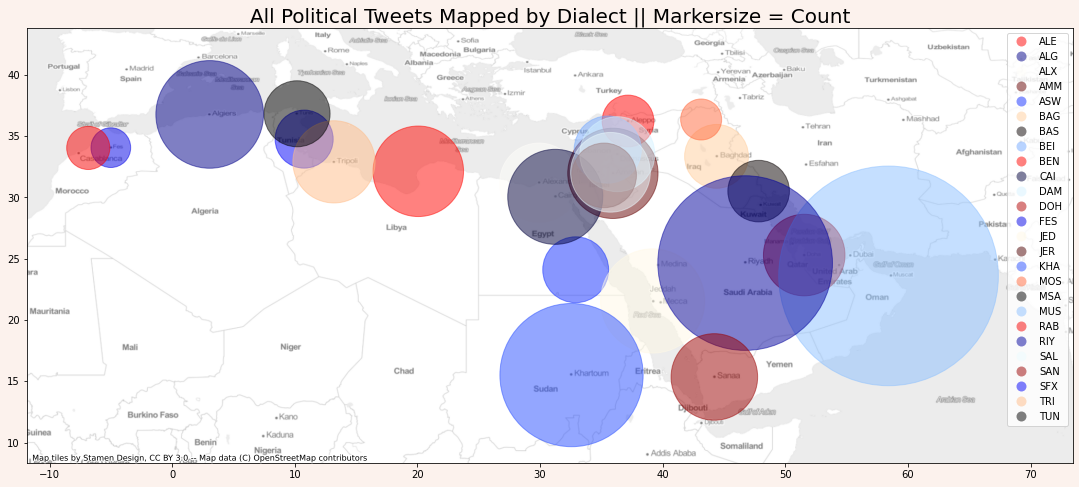

In [112]:
# plot all dialect data, colored by city and markersize increasing by count 
fig, ax = plt.subplots(figsize=(20,8))

fig.set_facecolor("#fcf2ed")

ylim = (df_merged.latitude.min() - 7,  df_merged.latitude.max() + 7)
xlim = (df_merged.longitude.min() - 5,  df_merged.longitude.max() + 15)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

gdf.plot(ax=ax, 
         alpha=0.5, 
         markersize='city_count', 
         column='city',
         cmap='flag',
         #cmap='Accent',
         legend=True)

plt.title('All Political Tweets Mapped by Dialect || Markersize = Count', fontsize=20)

ctx.add_basemap(ax=ax, 
               crs=4326, 
               alpha=0.5,
               source=ctx.providers.Stamen.TonerLite)

plt.savefig('/Users/richard/Desktop/springboard_repo/capstones/three/figures/dialect_mapping.png');

## GSDMM Topics Wordclouds

In [17]:
cluster_24 = [('اللَّه_1', 8700), ('قَلْب_3', 4395), ('لِ_1', 3716), ('أَنَّ_1', 3126), ('اللّٰهُمَّ_1', 2884), ('رَبّ_1', 2845), ('أَنا_1', 2816), ('قال', 2509), ('خَيْر_1', 2292), ('أَنْتَ_1', 2245), ('لَيّ_1', 2138), ('أَحَبّ_1', 2086), ('حُبّ_1', 2056), ('حَياة_1', 2027), ('كان_1', 1878), ('شَيْء_1', 1732), ('كُلّ_1', 1594), ('ناس_1', 1563), ('نَفْس_1', 1422), ('دَعْم_1', 1355)]

cluster_29 = [('الله_1_0', 5516), ('دعم_1_0', 2866), ('قروب_0_0', 2730), ('ل_1_0', 2597), ('قلب_3_0', 2387), ('رب_1_0', 1704), ('أنا_1_0', 1680), ('أن_1_0', 1672), ('لي_1_0', 1537), ('قال-u_1_0', 1518), ('اللهم_1_0', 1505), ('خير_1_0', 1429), ('حياة_1_0', 1416), ('أنت_1_0', 1362), ('سعودي_1_0', 1302), ('كان_1_0', 1245), ('أحب_1_0', 1230), ('كل_1_0', 1158), ('حب_1_0', 1151), ('من_1_0', 1143)]

cluster_23 = [('سَعُودِيّ_1', 1628), ('رِياض_1', 1018), ('اللَّه_1', 1013), ('قَطَر_1', 989), ('عَرَبِيّ_1', 965), ('هِلال_3', 906), ('أَمارَة_1', 868), ('مُحَمَّد_1', 837), ('جَدِيد_1', 758), ('دَوْلَة_1', 728), ('رَئِيس_1', 715), ('سُودان_1', 713), ('سِعْر_1', 649), ('أَهْلِيّ_1', 631), ('ال_1', 628), ('عَمَل_1', 620), ('بَلَد_1', 610), ('حِساب_2', 597), ('لِيبِيا_1', 597), ('ساعَة_1', 593)]

cluster_28 = [('سكس_0', 4876), ('لَم_1', 1140), ('فِيلْم_1', 996), ('نِيّ_1', 932), ('قَحْبَة_1', 801), ('خَلْفَ_1', 756), ('شَرْمُوطَة_2', 740), ('رابَط_1', 622), ('ممحونه_0', 575), ('مربربه_0', 440), ('حَلّ_1', 417), ('خَلِيجِيّ_2', 412), ('سِحاق_1', 408), ('سَعُودِيّ_1', 406), ('كسها_0', 393), ('مَصّ_2', 391), ('أَثار_1', 384), ('عَنِيف_1', 378), ('زُبّ_1', 377), ('جِنْس_1', 365)]

cluster_8 = [('قرض_1_0', 1678), ('تسديد_1_0', 1549), ('أهلي_1_0', 1074), ('بنك_1_0', 1014), ('راجحي_1_0', 991), ('رياض_1_0', 793), ('سداد_1_0', 656), ('متعثر_1_0', 536), ('راتب_1_0', 521), ('سامبا_1_0', 507), ('عربي_1_0', 465), ('إنماء_1_0', 447), ('بلد_1_0', 436), ('طريق_1_0', 383), ('شرعية_1_0', 370), ('سمة_1_0', 347), ('أبو_1_0', 263), ('جميع_1_0', 250), ('قرض_2_0', 221), ('سم_1_0', 209)]

cluster_10 = [('سوريا_1_0', 352), ('ريف_1_0', 342), ('حلب_1_0', 209), ('طيران_1_0', 200), ('ٱستهدف_1_0', 190), ('مدينة_1_0', 184), ('قوة_1_0', 169), ('أسد_1_0', 161), ('دمشق_1_0', 161), ('قصف_1_0', 133), ('غارة_1_0', 129), ('شرقي_1_0', 128), ('ثائر_2_0', 118), ('غوطة_1_0', 112), ('بلد_1_0', 110), ('جوي_1_0', 108), ('نظام_1_0', 107), ('حي_3_0', 94), ('روسي_1_0', 91), ('ادلب_0_0', 89)]

cluster_16 = [('شَرِكَة_1', 941), ('رِياض_1', 819), ('تَنْظِيف_1', 801), ('قَرْض_1', 382), ('نَقْل_1', 285), ('تَسْدِيد_1', 278), ('بَنْك_1', 278), ('سَداد_1', 214), ('أَهْلِيّ_1', 201), ('أَثاث_1', 170), ('عَفْش_1', 159), ('راجِحِيّ_1', 156), ('مُكافَحَة_1', 151), ('مَجْلِس_1', 150), ('مُتَعَثِّر_1', 140), ('راتِب_1', 140), ('شَقَّة_1', 134), ('خَزّان_1', 127), ('فَلَّل_1', 123), ('مُكَيِّفات_1', 118)]

cluster_1 = [('تنظيف_1_0', 673), ('شركة_1_0', 571), ('ماء_1_0', 446), ('رياض_1_0', 405), ('خزان_1_0', 359), ('كشف-i_1_0', 326), ('عزل_1_0', 319), ('تسرب_1_0', 285), ('سطح_2_0', 222), ('مكافحة_1_0', 210), ('حشرة_1_0', 175), ('غسيل_1_0', 160), ('مجلس_1_0', 149), ('عازلة_1_0', 147), ('شقة_1_0', 136), ('نقل_1_0', 135), ('حمام_1_0', 132), ('منزل_1_0', 130), ('فلل_1_0', 130), ('ضمان_1_0', 127)]

cluster_12 = [('عَزْل_1', 284), ('ماء_1', 191), ('كَشَف-i_1', 185), ('تَسَرُّب_1', 163), ('سَطْح_2', 148), ('خَزّان_1', 110), ('مُبَلَّط_1', 59), ('حَمّام_1', 58), ('حَلّ_1', 51), ('ٱِرْتِفاع_1', 51), ('فاتُورَة_1', 49), ('عازِلَة_1', 38), ('شَرِكَة_1', 36), ('رِياض_1', 36), ('ضَمان_1', 36), ('دُون_1', 32), ('تَكْسِير_1', 31), ('فُوم_1', 31), ('مَطْبَخ_1', 28), ('حَرارِيّ_1', 28)]

cluster_5 = [('تَمْوِيل_1', 175), ('حَتَّى_1', 153), ('قَرْض_2', 132), ('كَفِيل_2', 109), ('شَرْعِيّ_1', 87), ('خَصْم_1', 79), ('دُون_1', 79), ('أَعْطَى_1', 66), ('يبدء_0', 65), ('شَخْصِيّ_1', 58), ('سدادالمبكر_0', 33), ('سَداد_1', 24), ('مُبَكِّر_1', 21), ('جَمِيع_1', 19), ('طَلَب_2', 18), ('مِنْطَقَة_1', 18), ('المملكهتقدم_0', 11), ('شخصيبدون_0', 8), ('تَقَدَّم_1', 7), ('مَمْلَكَة_1', 7)]

Run the cell below a number of times. Just do a Find/Replace on the cluster names, depending on which cluster you want.

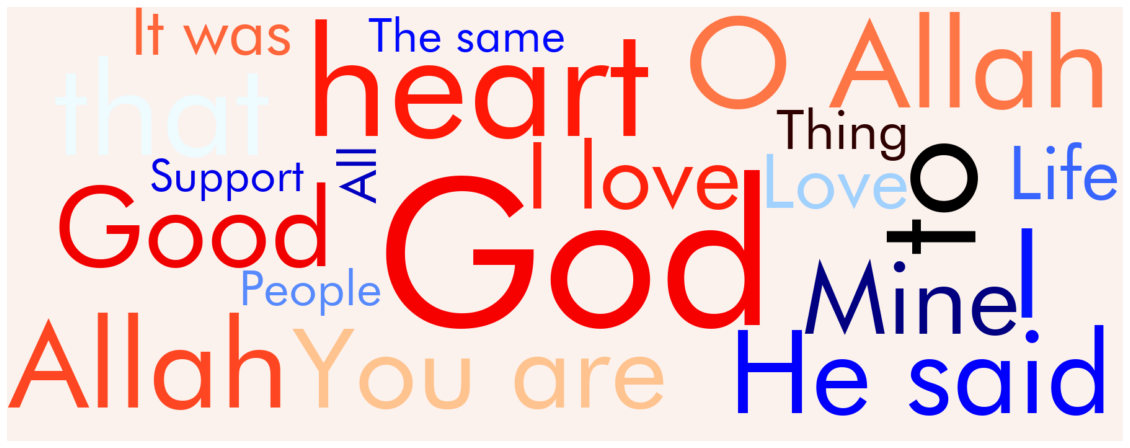

In [98]:
cluster_24l = []

# turn list of tuples into list of lists
for tup in cluster_24:
    cluster_24l.append(list(tup))
    
# remove non-arabic characters from lefmmas
for pair in cluster_24l:
    pair[0] = re.sub(pattern_notArabic, '', pair[0])
    
# instantiate translator
translator = GoogleTranslator(source='ar', target='en')

# translate
for pair in cluster_24l:
    pair[0] = translator.translate(pair[0])

# turn into dictionary
cluster_24dict = {}
for pair in cluster_24l:
    cluster_24dict[pair[0]] = pair[1]

# Generate a word cloud image
wordcloud_24 = WordCloud(background_color='#fcf2ed', 
                            width=1800,
                            height=700,
                            font_path='/System/Library/Fonts/Futura Book font.ttf',
                            colormap='flag').generate_from_frequencies(cluster_24dict)

fig, ax = plt.subplots(figsize=[20,10])
plt.imshow(wordcloud_24, interpolation='bilinear')
plt.axis("off");

wordcloud_24.to_file("/Users/richard/Desktop/springboard_repo/capstones/three/figures/gsdmm_topic_24_wordcloud_wide.png")